# 총 4 개
1. 간단한 클러스터링 -> 
2. 다중 군집 기반으로 다중 추천 ->
3. 

# 1 [간단 버전] KMeans 클러스터링 후 Cluster 1만 추천
KMeans(n=3) 클러스터링 →

PCA로 2D 시각화 →

Cluster 1에 속한 행정동명 출력

Silhouette Score: 0.2820
            0~9세  실내놀이터+키즈카페  주변_키즈카페_포함   소득분위  혼잡빈도강도_평일  혼잡시간강도_평일
cluster                                                              
0         729.75       0.875       2.875  5.875       84.0     91.125
1        1774.00       0.500       0.500  8.000       71.5     82.000
2        1095.40       1.800       2.600  6.800       63.4     77.400


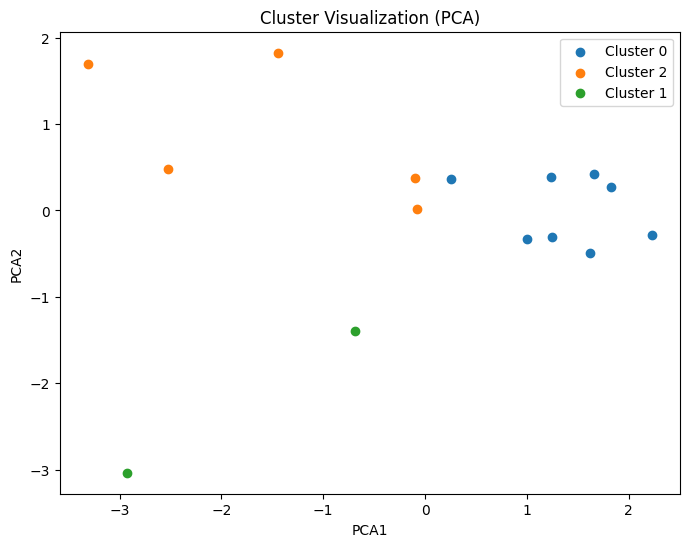

🔹 Cluster 1 (가장 유망한 키즈카페 입지 후보) 🔹
- 광장동
- 자양2동


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv('./data/중심좌표_통합.csv')

# 2. 사용할 feature 선택
features = ['0~9세', '실내놀이터+키즈카페', '주변_키즈카페_포함', '소득분위', '혼잡빈도강도_평일', '혼잡시간강도_평일']
X = df[features].copy()

# 3. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. KMeans 클러스터링
k = 3 
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df['cluster'] = labels

# 5. Silhouette Score
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {score:.4f}")

# 6. 클러스터별 평균 특성 확인
cluster_summary = df.groupby('cluster')[features].mean()
print(cluster_summary)

# 7. 시각화 (PCA로 2D 축소)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
for c in df['cluster'].unique():
    plt.scatter(df[df['cluster']==c]['pca1'], df[df['cluster']==c]['pca2'], label=f'Cluster {c}')
plt.legend()
plt.title('Cluster Visualization (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()
# Cluster 1에 속한 행정동명 뽑기
cluster_1_dongs = df[df['cluster'] == 1]['행정동명'].tolist()

print("🔹 Cluster 1 (가장 유망한 키즈카페 입지 후보) 🔹")
for dong in cluster_1_dongs:
    print(f"- {dong}")


# 2 [다중 군집 기반] 클러스터별 추천 + 다중 추천 빈도 계산

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'  # macOS 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지


1. 본 분석은 서울시 행정동 단위 데이터를 기반으로
"영유아 인구는 많고, 키즈카페는 부족한 지역" 을 추천하는 것을 목표로 한다.

특히 하나의 군집 방법에만 의존하지 않고,
KMeans, Hierarchical Clustering을 동시에 적용하여
다중 알고리즘 관점에서 교차 추천 빈도를 분석하는 방식을 사용했다.

2. 분석 프로세스
2.1 데이터 준비 및 전처리
중심좌표_통합.csv 파일을 불러오고, 결측값은 0으로 채움.

추가적으로 다음과 같은 파생 변수를 생성:

영유아인구: 0~4세 + 5~9세

공간반영_키즈카페수: 실내놀이터+키즈카페 수와 주변 키즈카페 수를 가중 평균(alpha=0.6)하여 반영.

coldspot 여부: 주변 대비 키즈카페 수가 부족한 지역(coldspot=1).

2.2 클러스터링 변수 선정
최종 사용 변수 (features) :
['영유아인구', '공간반영_키즈카페수', '유아당놀이터비율', '혼잡빈도강도_평일', 'coldspot']

2.3 데이터 표준화 및 차원 축소
StandardScaler를 이용해 데이터 스케일 조정.

PCA (n_components=2)를 적용하여 차원 축소 및 시각화 기반 구조 파악

3. 군집 분석
3.1 KMeans 클러스터링
3개의 클러스터로 분할.

PCA1, PCA2 공간에서 군집 분포를 시각화하여 확인.

3.2 Hierarchical(Agglomerative) Clustering
3개의 클러스터로 분할.

동일하게 PCA 결과를 활용하여 시각화.

4. 우선 추천 클러스터 선정 기준
각 클러스터의 평균 지표를 계산하여,
다음 기준에 부합하는 우선 추천 클러스터를 선정:

영유아인구 많음 (높을수록 좋음)

키즈카페 수 적음 (낮을수록 좋음)

유아당 놀이터 비율 높음 (높을수록 좋음)

이 기준을 get_priority_cluster() 함수로 자동화.

5. 최종 추천 방식
5.1 교차 추천 빈도 분석
KMeans 추천, Hierarchical 추천 각각의 행정동을 수집.

추천된 행정동들을 합쳐서, 등장 빈도를 계산.

추천 빈도가 높은 행정동을 우선순위로 선정.

5.2 시각화
추천 빈도를 Bar Chart로 시각화하여 직관적인 결과 제공.



KMeans, Hierarchical 다 돌림

둘 다 돌린 결과 겹치는 동들 추천

PCA 결과 시각화 + 추천 빈도 barplot 표시



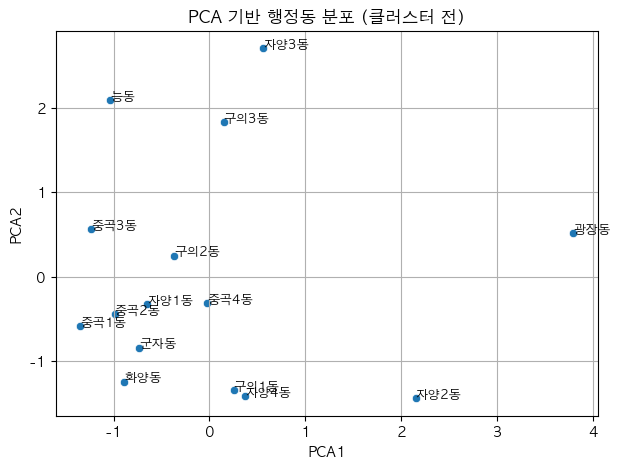

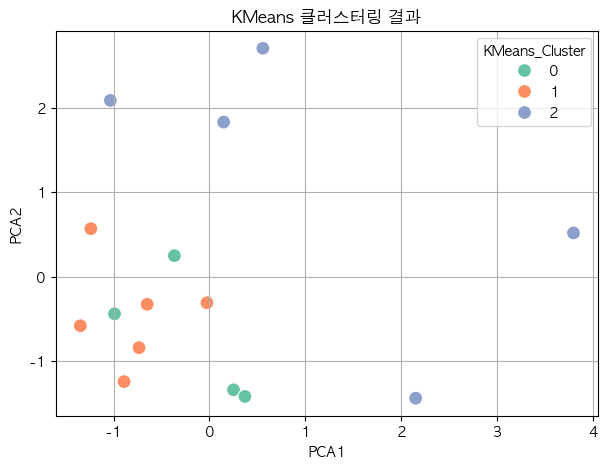

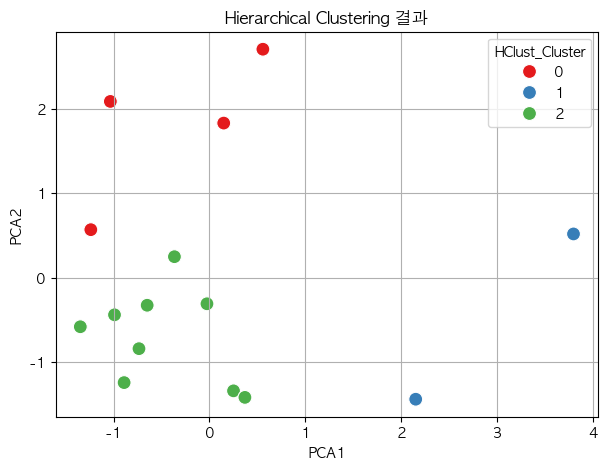

/var/folders/bc/_wqc9krd0ns0rld893yr8vfh0000gn/T/ipykernel_16069/192243655.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final, x='행정동명', y='추천빈도', palette='Blues_d')
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


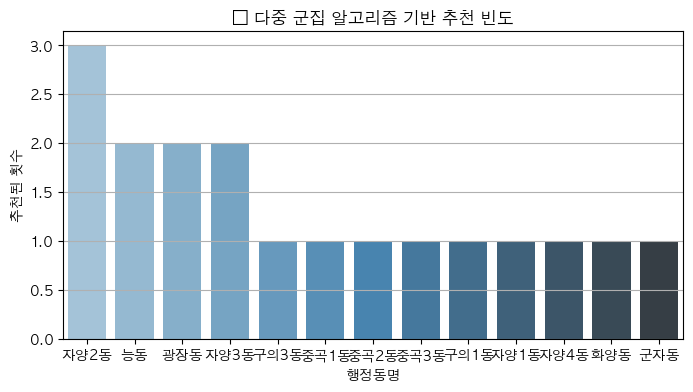

📌 다중 군집 기반 최종 추천 행정동


,행정동명,추천빈도
0,자양2동,3
1,능동,2
2,광장동,2
3,자양3동,2
4,구의3동,1
5,중곡1동,1
6,중곡2동,1
7,중곡3동,1
8,구의1동,1
9,자양1동,1


In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
df = pd.read_csv("./data/중심좌표_통합.csv")
df.fillna(0, inplace=True)

# 2. 변수 생성
df['영유아인구'] = df['0~4세'] + df['5~9세']
alpha = 0.6
df['공간반영_키즈카페수'] = (
    alpha * df['실내놀이터+키즈카페'] +
    (1 - alpha) * df['주변_키즈카페_포함']
)
df['coldspot'] = (df['실내놀이터+키즈카페'] < df['주변_키즈카페_포함']).astype(int)

# 3. 클러스터링 변수 준비
features = ['영유아인구', '공간반영_키즈카페수', '유아당놀이터비율', '혼잡빈도강도_평일', 'coldspot']
X = df[features]

# 4. 표준화 및 PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# 4-1. PCA 결과 시각화
plt.figure(figsize=(7, 5))
sns.scatterplot(x='PCA1', y='PCA2', data=df)
for i in range(len(df)):
    plt.text(df['PCA1'][i], df['PCA2'][i], df['행정동명'][i], fontsize=9)
plt.title("PCA 기반 행정동 분포 (클러스터 전)")
plt.grid(True)
plt.show()

# 5. KMeans 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# 5-1. KMeans 시각화
plt.figure(figsize=(7, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=df, palette='Set2', s=100)
plt.title("KMeans 클러스터링 결과")
plt.grid(True)
plt.show()

# 6. Hierarchical 클러스터링
agg = AgglomerativeClustering(n_clusters=3)
df['HClust_Cluster'] = agg.fit_predict(X_scaled)

# 6-1. Hierarchical 시각화
plt.figure(figsize=(7, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='HClust_Cluster', data=df, palette='Set1', s=100)
plt.title("Hierarchical Clustering 결과")
plt.grid(True)
plt.show()


# 8. 우선 클러스터 추출 함수
def get_priority_cluster(df, cluster_col):
    summary = df.groupby(cluster_col)[features].mean()
    return summary.sort_values(by=['영유아인구', '공간반영_키즈카페수', '유아당놀이터비율'],
                                ascending=[False, True, True]).index[0]

k_priority = get_priority_cluster(df, 'KMeans_Cluster')
h_priority = get_priority_cluster(df, 'HClust_Cluster')

# 9. 각 알고리즘 우선 추천 동 추출
k_best = df[df['KMeans_Cluster'] == k_priority]['행정동명']
h_best = df[df['HClust_Cluster'] == h_priority]['행정동명']

# 10. 교차 등장 동 추천 빈도 계산
all_best = pd.concat([k_best, h_best, d_best])
final = all_best.value_counts().reset_index()
final.columns = ['행정동명', '추천빈도']
final = final.sort_values(by='추천빈도', ascending=False)

# 10-1. 추천 결과 시각화
plt.figure(figsize=(8, 4))
sns.barplot(data=final, x='행정동명', y='추천빈도', palette='Blues_d')
plt.title("✅ 다중 군집 알고리즘 기반 추천 빈도")
plt.ylabel("추천된 횟수")
plt.xlabel("행정동명")
plt.grid(axis='y')
plt.show()

# 11. 최종 출력
print("📌 다중 군집 기반 최종 추천 행정동")
display(final)


# 3. 중요 변수 선정 + KMeans + 거리 기반 최적 입지 선정 

1. 본 프로젝트는 서울시 행정동 단위 데이터를 기반으로, 키즈카페 신규 입지를 추천하는 것을 목표로 한다.
PCA, 군집 기반 분석, RFE를 통한 중요 변수 선정 후,
KMeans 클러스터링 및 거리 기반 최적 입지 선정을 통해 최종 추천 행정동을 도출하였다.

2. 데이터 준비 및 전처리
분석 대상 변수(all_features)를 정의하고, 데이터(중심좌표_통합.csv)를 불러옴.

결측값을 0으로 처리하고, StandardScaler를 통해 모든 변수를 표준화함.

3. 차원 축소 및 시각화
StandardScaler를 통한 데이터 표준화.

PCA (주성분 분석)을 통해 2차원 축소 →
데이터 분포를 직관적으로 확인.

PCA1, PCA2 좌표계에 행정동명을 매핑하여 데이터 구조 파악.

4. 군집 분석 (1차)
4.1 KMeans 클러스터링
3개 군집으로 나누고 PCA 공간에 시각화.

4.2 Hierarchical (Agglomerative) Clustering
다른 방식으로 3개 군집 분할 후 PCA 공간에 시각화.

5. 중요 변수 최적화
추가로 all_features를 정의하여
PCA 로딩 점수, KMeans 기반 표준편차 분석, RFE(Recursive Feature Elimination)로 각각 중요 변수를 선정.

세 가지 방식 모두에 공통으로 등장한 변수만 추출 →
가장 의미 있는 핵심 변수(common_vars_1) 을 최종 확정.

6. 중요 변수 기반 클러스터링 (2차)
최종 선정된 중요 변수만으로 다시 KMeans 클러스터링 진행.

군집별 평균값 비교:

영유아인구가 많고

공간반영 키즈카페 수가 적은 군집을 추천 클러스터로 선정.

해당 군집에 속한 행정동을 1차 추천 후보로 선정.

7. 공간적 거리 기반 Top 추천
1차 추천 후보군 중 평균 거리가 가장 짧은 5개 동을 선정.

그 중 중심점(lat, lon 평균)과 가장 가까운 2개 동을
최종 최적 추천 동으로 추출.

8. 다중 기준 추천 종합
세 가지 추천 경로를 모두 통합:

KMeans 우선 추천

Hierarchical 우선 추천

거리 기반 최종 추천

세 방법에서 추천된 행정동을 모아
추천 빈도를 계산하고,
빈도가 높은 행정동을 최종 우선순위로 추천.


| 항목 | 이유 |
|:---|:---|
| 다중 군집 알고리즘 사용 | 하나의 클러스터링 방식만 쓰면 편향 발생 가능.<br>서로 다른 방법(KMeans, Hierarchical)을 통해 일관성 있는 추천을 확보. |
| 변수 최적화(PCA, RFE 등) | 데이터 특징을 더 잘 반영하는 변수를 찾고,<br>군집 결과를 왜곡 없이 반영하기 위해. |
| 거리 기반 Top 추천 추가 | 군집만 보면 빠질 수 있는 공간적 중심성을 보완.<br>입지 전략에 맞는 추천 가능. |
| 추천 빈도 기반 최종 선정 | 여러 방법에서 동시 추천된 지역을 우선시하여<br>결과 신뢰성을 높임. |
| 명확한 추천 기준 설정 | "영유아 많고, 키즈카페 적고, 놀이터 많은 지역"이라는<br>구체적 수치 기준으로 우선순위를 결정. |



PCA 상위 변수: ['유아당놀이터비율', '혼잡시간강도_평일', '혼잡빈도강도_평일', '실내놀이터+키즈카페', '5~9세']
군집 기반 상위 변수: ['유아당놀이터비율', '5~9세', '0~4세', '혼잡빈도강도_평일', '혼잡시간강도_평일']
RFE 적용 중요 변수: ['세대당인구', '주변_키즈카페_포함', '혼잡시간강도_평일', '유아당놀이터비율', '혼잡빈도강도_평일']
공통 중요 변수: ['혼잡시간강도_평일', '유아당놀이터비율', '혼잡빈도강도_평일']
📊 군집별 변수 평균:
                 혼잡시간강도_평일    유아당놀이터비율  혼잡빈도강도_평일
Selected_KMeans                                  
0                     87.5  996.750000  79.500000
1                     77.4  389.950000  63.400000
2                     90.5  326.416667  82.833333
✅ 추천 대상 행정동:
    행정동명        lat         lon
0   중곡1동  37.562037  127.077722
1   중곡2동  37.558909  127.084587
2   중곡3동  37.567851  127.081970
6   구의2동  37.551002  127.094450
13   화양동  37.543265  127.073460
14   군자동  37.553066  127.073681


/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 5083

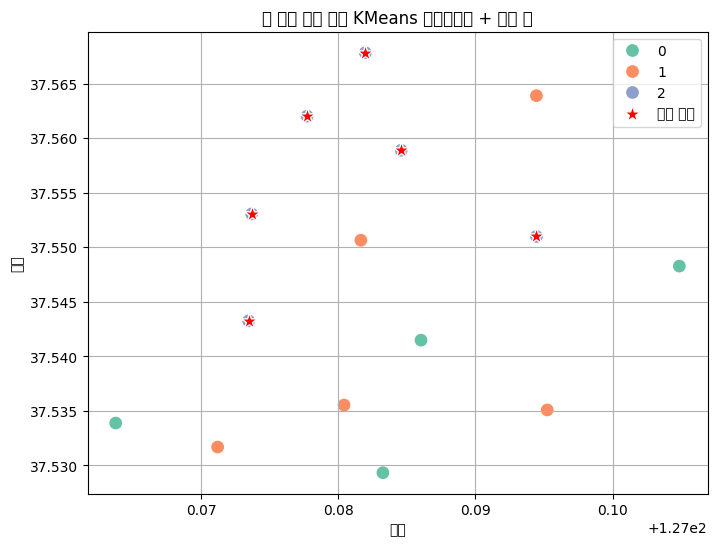

중심점 기준 최적 추천된 행정동 2개
    행정동명        lat         lon
0   중곡1동  37.562037  127.077722
14   군자동  37.553066  127.073681


/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gim-yeseul/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph

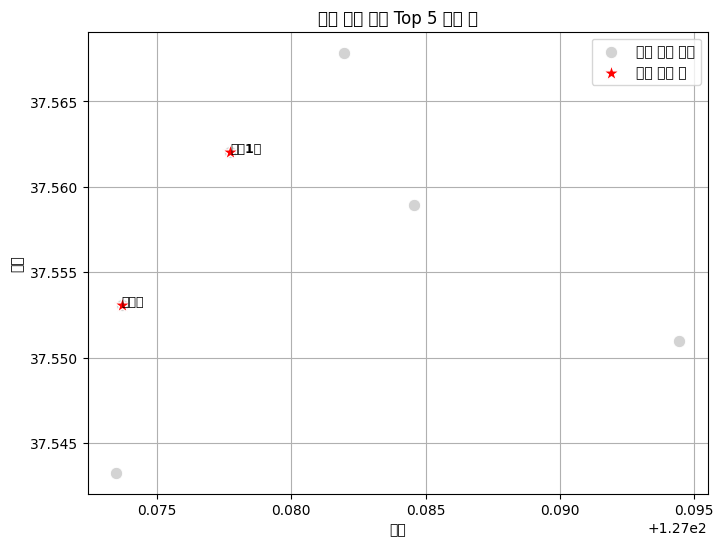

최종 최적 추천된 행정동 목록
    행정동명        lat         lon
0   중곡1동  37.562037  127.077722
14   군자동  37.553066  127.073681


In [2]:
# 📌 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform, cdist
from itertools import combinations

# 📌 1. 데이터 불러오기 및 전처리
df = pd.read_csv("./data/중심좌표_통합.csv")
df.fillna(0, inplace=True)  # 결측값은 0으로 채움

# 📌 2. 파생 변수 생성
df['영유아인구'] = df['0~4세'] + df['5~9세']  # 영유아 인구 합산
alpha = 0.6  # 가중 평균 비율
df['공간반영_키즈카페수'] = (
    alpha * df['실내놀이터+키즈카페'] +
    (1 - alpha) * df['주변_키즈카페_포함']
)
df['coldspot'] = (df['실내놀이터+키즈카페'] < df['주변_키즈카페_포함']).astype(int)  # 키즈카페 부족 지역 표시

# 📌 3. 클러스터링 대상 변수 선택
all_features = [
    '0~4세', '5~9세', '세대당인구', '주변_키즈카페_포함', '혼잡시간강도_평일',
    '유아당놀이터비율', '혼잡빈도강도_평일', '저소득자수', '실내놀이터+키즈카페'
]
features = ['영유아인구', '공간반영_키즈카페수', '유아당놀이터비율', '혼잡빈도강도_평일', 'coldspot']

# 📌 4. 데이터 표준화 및 PCA 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[all_features])

pca = PCA(n_components=2)
pca.fit(X_scaled)

# 📌 5. PCA 로딩 기반 중요 변수 선정
loading_scores = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=all_features
)
loading_scores['합'] = loading_scores['PC1'].abs() + loading_scores['PC2'].abs()
top_pca_vars = loading_scores.sort_values(by='합', ascending=False).head(5).index.tolist()

# 📌 6. KMeans 클러스터링 (전체 feature 기준)
if 'KMeans' not in df.columns:
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['KMeans'] = kmeans.fit_predict(X_scaled)

# 📌 7. 군집별 평균 및 표준편차 기반 중요 변수 선정
group_means = df.groupby('KMeans')[all_features].mean().T
group_means['표준편차'] = group_means.std(axis=1)
top_cluster_vars = group_means['표준편차'].sort_values(ascending=False).head(5).index.tolist()

# 📌 8. RFE(Recursive Feature Elimination)로 변수 최적화
model = RandomForestClassifier(random_state=42)
selector = RFE(model, n_features_to_select=5)
selector = selector.fit(X_scaled, df['KMeans'])
selected_vars = [feature for feature, selected in zip(all_features, selector.support_) if selected]

# 📌 9. PCA, 군집기반, RFE 결과를 비교하여 공통 중요 변수 도출
common_vars = list(set(top_pca_vars) & set(top_cluster_vars))
common_vars_1 = list(set(common_vars) & set(selected_vars))

# 📌 10. 중요 변수 결과 출력
print("PCA 상위 변수:", top_pca_vars)
print("군집 기반 상위 변수:", top_cluster_vars)
print("RFE 적용 중요 변수:", selected_vars)
print("공통 중요 변수:", common_vars_1)

# 📌 11. 중요 변수 기반 데이터프레임 구성
important_df = df[common_vars_1 + ['행정동명', 'lat', 'lon']]

# 📌 12. 중요 변수 기반 다시 클러스터링
X_selected = df[common_vars_1]
X_scaled_selected = scaler.fit_transform(X_selected)

kmeans_final = KMeans(n_clusters=3, random_state=42)
df['Selected_KMeans'] = kmeans_final.fit_predict(X_scaled_selected)

# 📌 13. 군집별 평균 분석
summary = df.groupby('Selected_KMeans')[common_vars_1].mean()
print("📊 군집별 변수 평균:")
print(summary)

# 📌 14. 추천 군집 자동 선택 (영유아인구 많고, 키즈카페 적은 군집)
recommend_cluster = summary.sort_values(
    by=[common_vars_1[0], common_vars_1[1]],
    ascending=[False, True]
).index[0]

# 📌 15. 추천 행정동 추출
recommended_df = df[df['Selected_KMeans'] == recommend_cluster]
print("✅ 추천 대상 행정동:")
print(recommended_df[['행정동명', 'lat', 'lon']])

# 📌 16. 지도 시각화 (추천 행정동 표시)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='lon', y='lat', hue='Selected_KMeans', palette='Set2', s=100)
sns.scatterplot(data=recommended_df, x='lon', y='lat', color='red', s=150, label='추천 동네', marker='*')
plt.title("📍 중요 변수 기반 KMeans 클러스터링 + 추천 동")
plt.xlabel("경도")
plt.ylabel("위도")
plt.grid(True)
plt.legend()
plt.show()

# 📌 17. 추천된 후보 중 거리 기반 Top 5 선정
coords = recommended_df[['lat', 'lon']].values
dist_matrix = squareform(pdist(coords, metric='euclidean'))
avg_distances = dist_matrix.mean(axis=1)
top5_idx = np.argsort(avg_distances)[:5]
recommended_top5 = recommended_df.iloc[top5_idx]

# 📌 18. Top 5 중 중심점 기준 최적 2개 동 선정
coords_top5 = recommended_top5[['lat', 'lon']].values
center = coords_top5.mean(axis=0).reshape(1, -1)
distances_to_center = cdist(coords_top5, center, metric='euclidean').flatten()
top2_idx = np.argsort(distances_to_center)[:2]
final_recommended = recommended_top5.iloc[top2_idx]

# 📌 19. 최종 추천 결과 출력
print("중심점 기준 최적 추천된 행정동 2개")
print(final_recommended[['행정동명', 'lat', 'lon']])

# 📌 20. 최종 추천 결과 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(data=recommended_df, x='lon', y='lat', color='lightgrey', s=80, label='추천 후보 전체')
sns.scatterplot(data=final_recommended, x='lon', y='lat', color='red', s=150, label='최종 추천 동', marker='*')
for i in range(len(final_recommended)):
    plt.text(final_recommended['lon'].iloc[i], final_recommended['lat'].iloc[i],
             final_recommended['행정동명'].iloc[i], fontsize=9, weight='bold')
plt.title("최종 공간 기반 Top 5 추천 동")
plt.xlabel("경도")
plt.ylabel("위도")
plt.grid(True)
plt.legend()
plt.show()

# 📌 21. 최종 최적 추천된 행정동 출력
print("최종 최적 추천된 행정동 목록")
print(final_recommended[['행정동명', 'lat', 'lon']])


# (최종) 다중 알고리즘 기반 최종 분석

광진구 내에서 키즈카페 신규 입지 후보 지역을 발굴하기 위해  
다양한 군집화 알고리즘과 지도학습 기반 다변수 분석을 결합하여 데이터 기반 최적 추천을 수행하였다.

본 분석은 서울시 행정동 단위 데이터를 기반으로  
**"영유아 인구가 많고, 키즈카페는 상대적으로 부족한 지역"** 을 추천하는 것이 목적이다.

단일 군집 결과에 의존하지 않고,  
(1) KMeans, (2) Hierarchical Clustering, (3) 거리 기반 Top 추천  
총 세 가지 방법을 통해 교차 추천 빈도를 분석하고 최종 우선 추천 행정동을 선정하였다.

---

## 1. 분석 목표

본 분석은 서울시 행정동 단위 데이터를 기반으로  
**"영유아 인구가 많고 키즈카페는 부족한 지역"** 을  
**다중 군집 알고리즘**과 **변수 최적화** 및 **거리 기반 분석**을 통해 종합적으로 추천하는 것을 목표로 한다.

---

## 2. 분석 프로세스

### 2.1 데이터 준비 및 전처리
- `중심좌표_통합.csv` 데이터 로딩, 결측치는 0으로 채움.
- 파생 변수 생성:
  - **영유아인구**: `0~4세` + `5~9세`
  - **공간반영_키즈카페수**: 실내놀이터+키즈카페 수와 주변 키즈카페 수를 가중 평균(α=0.6)으로 통합.
  - **coldspot**: 주변 대비 키즈카페 수가 부족하면 1, 아니면 0.

### 2.2 분석 변수(features) 1
- 분석에 사용된 변수: ['영유아인구', '공간반영_키즈카페수', '유아당놀이터비율', '혼잡빈도강도_평일', 'coldspot']


### 2.3 분석 변수(features) 2
- 추가적으로 중요 변수 교집합을 구하여 사용:
공통 중요 변수: ['혼잡시간강도_평일', '유아당놀이터비율', '혼잡빈도강도_평일']



---

## 3. 차원 축소 및 시각화

- `StandardScaler`를 통한 데이터 표준화
- `PCA (주성분 분석)`을 통해 2차원 축소하여 데이터 분포를 직관적으로 확인
- PCA1, PCA2 좌표계에 행정동명을 매핑하여 데이터 구조 파악

---

## 4. 군집 분석 (1차)

### 4.1 KMeans 클러스터링
- 3개 군집으로 나누고 PCA 공간에 시각화

### 4.2 Hierarchical (Agglomerative) Clustering
- 다른 방식으로 3개 군집 분할 후 PCA 공간에 시각화

---

## 5. 중요 변수 최적화

- 추가로 `all_features`를 정의하여  
- PCA 로딩 점수
- KMeans 기반 표준편차 분석
- RFE(Recursive Feature Elimination)
- 각각 중요 변수를 선정

- 세 가지 방식 모두에 공통으로 등장한 변수만 추출 →  
가장 의미 있는 핵심 변수(`common_vars_1`)를 최종 확정

---

## 6. 중요 변수 기반 클러스터링 (2차)

- 최종 선정된 중요 변수만으로 다시 KMeans 클러스터링 진행
- 군집별 평균값 비교:
- 영유아인구가 많고
- 공간반영 키즈카페 수가 적은 군집을 추천 클러스터로 선정
- 해당 군집에 속한 행정동을 **1차 추천 후보**로 선정

---

## 7. 공간적 거리 기반 Top 추천

- 1차 추천 후보군 중 **평균 거리가 가장 짧은 5개 동**을 선정
- 그 중 **중심점(lat, lon 평균)**과 가장 가까운 **2개 동**을 최종 최적 추천 동으로 추출

---

## 8. 다중 기준 추천 종합

- 세 가지 추천 경로를 모두 통합:
- KMeans 우선 추천
- Hierarchical 우선 추천
- 거리 기반 최종 추천
- 세 방법에서 추천된 행정동을 모아 추천 빈도를 계산하고,  
빈도가 높은 행정동을 최종 우선순위로 추천

---

## 9. 분석 요약

| 구분 | 설명 |
|:---|:---|
| 데이터셋 | 서울시 행정동 단위 데이터 |
| 주요 변수 | 영유아인구, 키즈카페수, 유아당놀이터비율 등 |
| 적용 방법 | KMeans, Hierarchical Clustering, PCA, RFE, 거리 기반 분석 |
| 최종 추천 방식 | 다중 알고리즘 교차 추천 + 추천 빈도 기반 최적 행정동 선정 |

---

## 10. 선택 방식 및 이유

| 항목 | 이유 |
|:---|:---|
| 다중 군집 알고리즘 사용 | 하나의 클러스터링 방식만 쓰면 편향 발생 가능.<br>서로 다른 방법(KMeans, Hierarchical)을 통해 일관성 있는 추천을 확보. |
| 변수 최적화(PCA, RFE 등) | 데이터 특징을 더 잘 반영하는 변수를 찾고,<br>군집 결과를 왜곡 없이 반영하기 위해. |
| 거리 기반 Top 추천 추가 | 군집만 보면 빠질 수 있는 **공간적 중심성**을 보완.<br>입지 전략에 맞는 추천 가능. |
| 추천 빈도 기반 최종 선정 | 여러 방법에서 동시 추천된 지역을 우선시하여<br>결과 신뢰성을 높임. |
| 명확한 추천 기준 설정 | "영유아 많고, 키즈카페 적고, 놀이터 많은 지역"이라는<br>구체적 수치 기준으로 우선순위를 결정. |

---



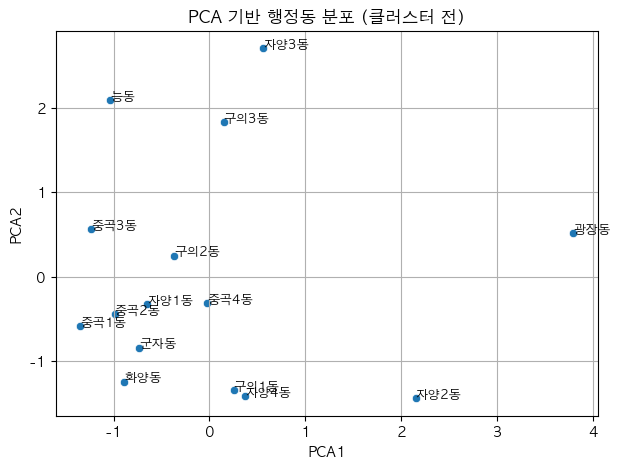

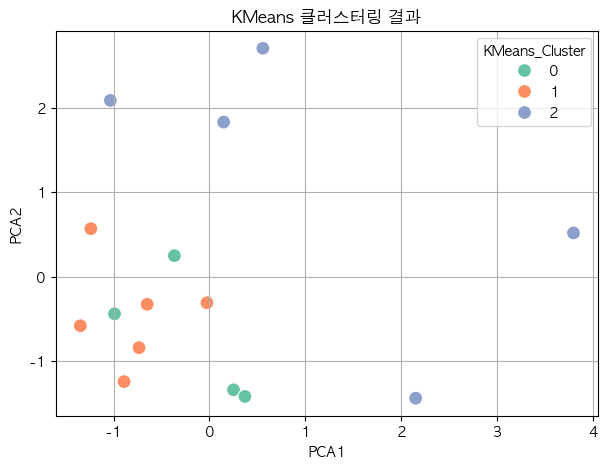

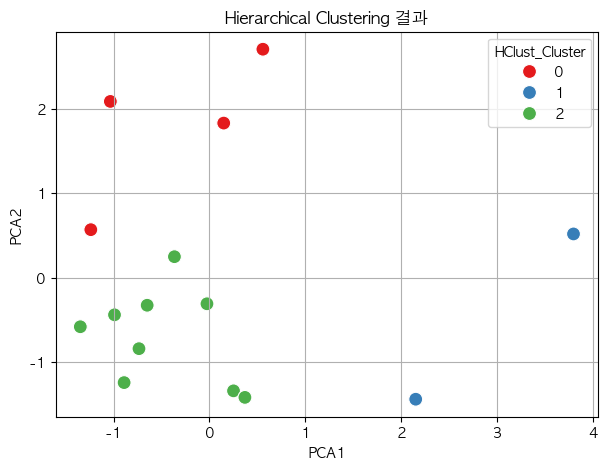

PCA 상위 변수: ['유아당놀이터비율', '혼잡시간강도_평일', '혼잡빈도강도_평일', '실내놀이터+키즈카페', '5~9세']
군집 기반 상위 변수: ['유아당놀이터비율', '5~9세', '0~4세', '혼잡빈도강도_평일', '혼잡시간강도_평일']
RFE 적용 중요 변수: ['세대당인구', '주변_키즈카페_포함', '혼잡시간강도_평일', '유아당놀이터비율', '혼잡빈도강도_평일']
공통 중요 변수: ['혼잡시간강도_평일', '유아당놀이터비율', '혼잡빈도강도_평일']
추천 대상 행정동:
    행정동명        lat         lon
0   중곡1동  37.562037  127.077722
1   중곡2동  37.558909  127.084587
2   중곡3동  37.567851  127.081970
6   구의2동  37.551002  127.094450
13   화양동  37.543265  127.073460
14   군자동  37.553066  127.073681


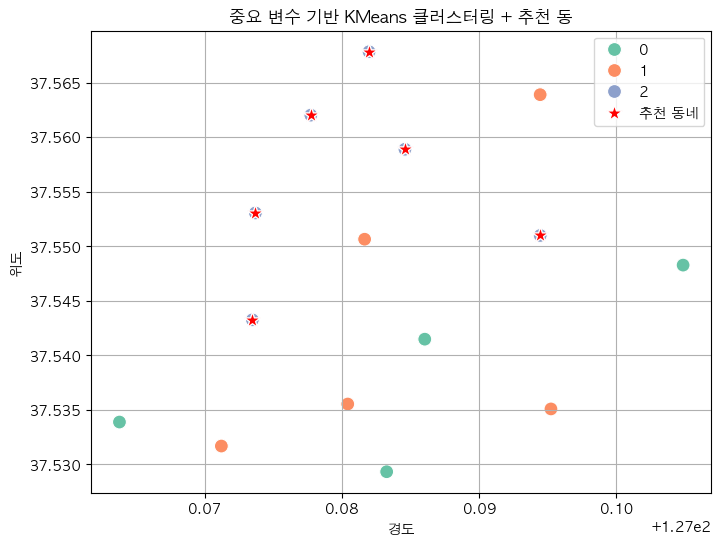

중심점 기준 최적 추천된 행정동 2개
    행정동명        lat         lon
0   중곡1동  37.562037  127.077722
14   군자동  37.553066  127.073681


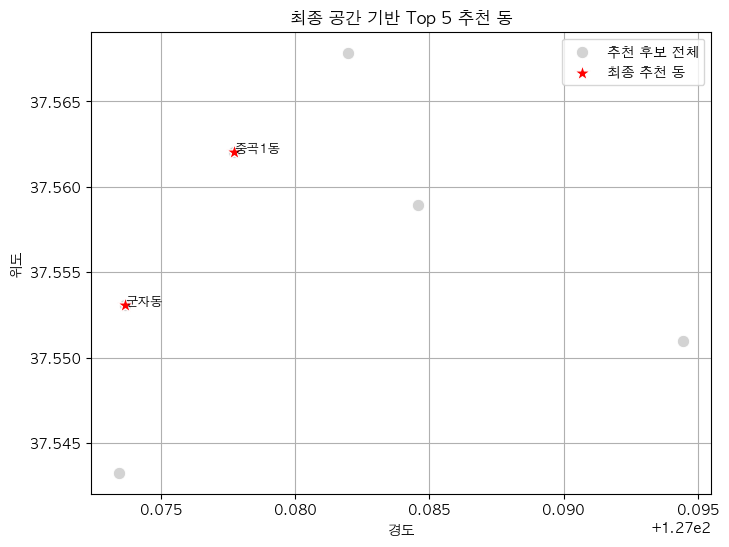

/var/folders/bc/_wqc9krd0ns0rld893yr8vfh0000gn/T/ipykernel_55379/984317724.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final, x='행정동명', y='추천빈도', palette='Blues_d')


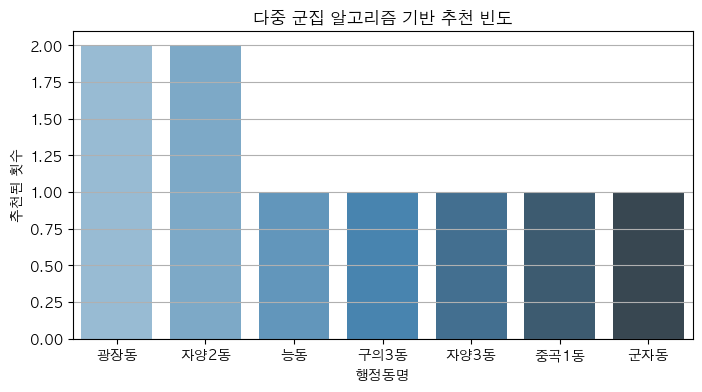

다중 군집 기반 최종 추천 행정동


,행정동명,추천빈도
0,광장동,2
1,자양2동,2
2,능동,1
3,구의3동,1
4,자양3동,1
5,중곡1동,1
6,군자동,1


In [3]:
# 📌 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정
mpl.rc('font', family='AppleGothic')  # 맥북이면 AppleGothic 쓰기
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# 📌 1. 데이터 불러오기 및 기본 전처리
df = pd.read_csv("./data/중심좌표_통합.csv")
df.fillna(0, inplace=True)  # 결측값을 0으로 채움

# 📌 2. 파생 변수 생성
df['영유아인구'] = df['0~4세'] + df['5~9세']  # 영유아 인구 합산
alpha = 0.6  # 키즈카페 반영 가중치 설정
df['공간반영_키즈카페수'] = (
    alpha * df['실내놀이터+키즈카페'] +
    (1 - alpha) * df['주변_키즈카페_포함']
)
df['coldspot'] = (df['실내놀이터+키즈카페'] < df['주변_키즈카페_포함']).astype(int)  # coldspot 여부(주변 대비 부족)

# 📌 3. 클러스터링 분석용 변수 선정
features = ['영유아인구', '공간반영_키즈카페수', '유아당놀이터비율', '혼잡빈도강도_평일', 'coldspot']
X = df[features]

# 📌 4. 표준화 및 PCA 수행
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# 📌 4-1. PCA 결과 시각화
plt.figure(figsize=(7, 5))
sns.scatterplot(x='PCA1', y='PCA2', data=df)
for i in range(len(df)):
    plt.text(df['PCA1'][i], df['PCA2'][i], df['행정동명'][i], fontsize=9)
plt.title("PCA 기반 행정동 분포 (클러스터 전)")
plt.grid(True)
plt.show()

# 📌 5. KMeans 클러스터링 (3개 군집)
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# 📌 5-1. KMeans 클러스터 결과 시각화
plt.figure(figsize=(7, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=df, palette='Set2', s=100)
plt.title("KMeans 클러스터링 결과")
plt.grid(True)
plt.show()

# 📌 6. Hierarchical Clustering (3개 군집)
agg = AgglomerativeClustering(n_clusters=3)
df['HClust_Cluster'] = agg.fit_predict(X_scaled)

# 📌 6-1. Hierarchical 결과 시각화
plt.figure(figsize=(7, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='HClust_Cluster', data=df, palette='Set1', s=100)
plt.title("Hierarchical Clustering 결과")
plt.grid(True)
plt.show()

# 📌 7. 추천 클러스터 자동 추출 함수 정의
def get_priority_cluster(df, cluster_col):
    summary = df.groupby(cluster_col)[features].mean()
    return summary.sort_values(by=['영유아인구', '공간반영_키즈카페수', '유아당놀이터비율'],
                                ascending=[False, True, True]).index[0]

k_priority = get_priority_cluster(df, 'KMeans_Cluster')
h_priority = get_priority_cluster(df, 'HClust_Cluster')

# 📌 8. 추가: 전체 feature 대상으로 변수 중요도 분석

# 전체 변수 리스트
all_features = [
    '0~4세', '5~9세', '세대당인구', '주변_키즈카페_포함',
    '혼잡시간강도_평일', '유아당놀이터비율', '혼잡빈도강도_평일',
    '저소득자수', '실내놀이터+키즈카페'
]

# 표준화 후 PCA 수행
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[all_features])
pca = PCA(n_components=2)
pca.fit(X_scaled)

# PCA 로딩 기반 상위 5개 변수 선정
loading_scores = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=all_features
)
loading_scores['합'] = loading_scores['PC1'].abs() + loading_scores['PC2'].abs()
top_pca_vars = loading_scores.sort_values(by='합', ascending=False).head(5).index.tolist()

# KMeans 군집별 평균 → 표준편차 기반 변수 선정
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans'] = kmeans.fit_predict(X_scaled)
group_means = df.groupby('KMeans')[all_features].mean().T
group_means['표준편차'] = group_means.std(axis=1)
top_cluster_vars = group_means['표준편차'].sort_values(ascending=False).head(5).index.tolist()

# RFE(Recursive Feature Elimination) 적용
model = RandomForestClassifier(random_state=42)
selector = RFE(model, n_features_to_select=5)
selector = selector.fit(X_scaled, df['KMeans'])
selected_vars = [feature for feature, selected in zip(all_features, selector.support_) if selected]

# 공통 중요 변수 추출
common_vars = list(set(top_pca_vars) & set(top_cluster_vars))
common_vars_1 = list(set(common_vars) & set(selected_vars))

# 결과 출력
print("PCA 상위 변수:", top_pca_vars)
print("군집 기반 상위 변수:", top_cluster_vars)
print("RFE 적용 중요 변수:", selected_vars)
print("공통 중요 변수:", common_vars_1)

# 📌 9. 중요 변수 기반 클러스터링
X_selected = df[common_vars_1]
X_scaled_selected = scaler.fit_transform(X_selected)

kmeans_final = KMeans(n_clusters=3, random_state=42)
df['Selected_KMeans'] = kmeans_final.fit_predict(X_scaled_selected)

# 📌 10. 최적 추천 클러스터 선택 (영유아 많고, 키즈카페 적은)
summary = df.groupby('Selected_KMeans')[common_vars_1].mean()
recommend_cluster = summary.sort_values(
    by=[common_vars_1[0], common_vars_1[1]],
    ascending=[False, True]
).index[0]

recommended_df = df[df['Selected_KMeans'] == recommend_cluster]
print("추천 대상 행정동:")
print(recommended_df[['행정동명', 'lat', 'lon']])

# 📌 11. 추천 행정동 지도 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='lon', y='lat', hue='Selected_KMeans', palette='Set2', s=100)
sns.scatterplot(data=recommended_df, x='lon', y='lat', color='red', s=150, label='추천 동네', marker='*')
plt.title("중요 변수 기반 KMeans 클러스터링 + 추천 동")
plt.xlabel("경도")
plt.ylabel("위도")
plt.grid(True)
plt.legend()
plt.show()

# 📌 12. 거리 기반 Top 5 → 중심점 기반 최적 Top 2 추출
coords = recommended_df[['lat', 'lon']].values
dist_matrix = squareform(pdist(coords, metric='euclidean'))
avg_distances = dist_matrix.mean(axis=1)
top5_idx = np.argsort(avg_distances)[:5]
recommended_top5 = recommended_df.iloc[top5_idx]

coords_top5 = recommended_top5[['lat', 'lon']].values
center = coords_top5.mean(axis=0).reshape(1, -1)
distances_to_center = cdist(coords_top5, center, metric='euclidean').flatten()
top2_idx = np.argsort(distances_to_center)[:2]
final_recommended = recommended_top5.iloc[top2_idx]

print("중심점 기준 최적 추천된 행정동 2개")
print(final_recommended[['행정동명', 'lat', 'lon']])

# 📌 13. 최종 추천 후보 지도 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(data=recommended_df, x='lon', y='lat', color='lightgrey', s=80, label='추천 후보 전체')
sns.scatterplot(data=final_recommended, x='lon', y='lat', color='red', s=150, label='최종 추천 동', marker='*')
for i in range(len(final_recommended)):
    plt.text(final_recommended['lon'].iloc[i], final_recommended['lat'].iloc[i],
             final_recommended['행정동명'].iloc[i], fontsize=9, weight='bold')
plt.title("최종 공간 기반 Top 5 추천 동")
plt.xlabel("경도")
plt.ylabel("위도")
plt.grid(True)
plt.legend()
plt.show()

# 📌 14. 다중 군집 기반 최종 추천
k_best = df[df['KMeans_Cluster'] == k_priority]['행정동명']
h_best = df[df['HClust_Cluster'] == h_priority]['행정동명']
rk_best = final_recommended['행정동명']

# 추천된 행정동 합산 및 추천 빈도 계산
all_best = pd.concat([k_best, h_best, rk_best])
final = all_best.value_counts().reset_index()
final.columns = ['행정동명', '추천빈도']
final = final.sort_values(by='추천빈도', ascending=False)

# 📌 15. 최종 추천 결과 시각화
plt.figure(figsize=(8, 4))
sns.barplot(data=final, x='행정동명', y='추천빈도', palette='Blues_d')
plt.title("다중 군집 알고리즘 기반 추천 빈도")
plt.ylabel("추천된 횟수")
plt.xlabel("행정동명")
plt.grid(axis='y')
plt.show()

# 📌 16. 최종 추천 결과 출력
print("다중 군집 기반 최종 추천 행정동")
display(final)
